In [1]:
from main import main
from PDconfig import ZonaP
from frames.archivosDF import *

main()
ruta_barrios = './DataFrames/MeLi/barrios.csv'
ruta_ciudades = './DataFrames/MeLi/ciudades.csv'
df = abrirDF(ZonaP)

In [2]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# ELIMINAR TIPO PROP INSERVIBLES
filt = df['tipoPropiedad'] == 'PH'
df.loc[filt, 'tipoPropiedad'] = "DEPARTAMENTO"
# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS"]


In [18]:
# FILTRADO DETALLADO INMUEBLES
# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles['fechaUltimaActualizacion'], format='%d-%m-%Y')

filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.005), 
                                          inmuebles["terrenoTotal"].quantile(0.999))
filtro_TE = inmuebles["terrenoEdificado"].between(inmuebles["terrenoEdificado"].quantile(0.005), 
                                          inmuebles["terrenoEdificado"].quantile(0.999))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.005), 
                                          inmuebles["precioUSD"].quantile(0.999))
filtro_F = (inmuebles['fechaUltimaActualizacion'].dt.year == 2023)

inmuebles_filt = inmuebles.loc[filtro_TT & filtro_TE & filtro_P & filtro_F]

filtro_TE = (inmuebles_filt['terrenoEdificado'] == 1) | (inmuebles_filt['terrenoTotal'] == 1)
inmuebles_filt.drop(inmuebles_filt[filtro_TE].index, inplace=True)

C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\843468217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles['fechaUltimaActualizacion'], format='%d-%m-%Y')
C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\843468217.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt.drop(inmuebles_filt[filtro_TE].index, inplace=True)


In [19]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\3911280188.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\3911280188.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']


40


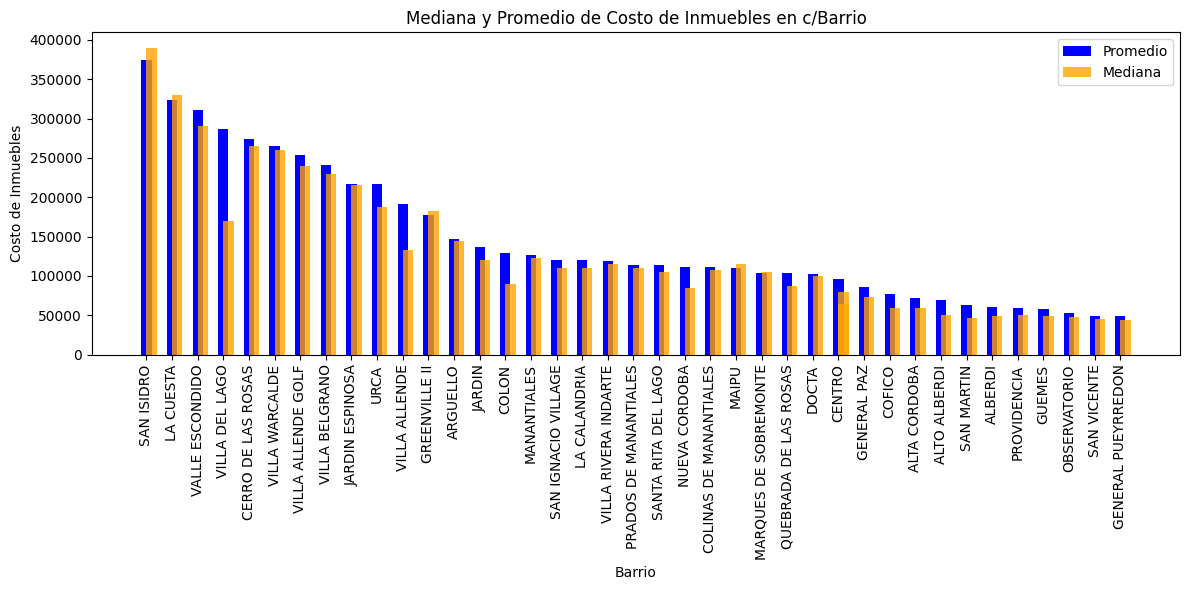

In [20]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean()
precio_m2_total_median = grouped_data['precio_m2_total'].median()
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean()
precio_m2_edif_median = grouped_data['precio_m2_edif'].median()

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\1982482442.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
C:\Users\ihorrocks\AppData\Local\Temp\ipykernel_60608\1982482442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']


20


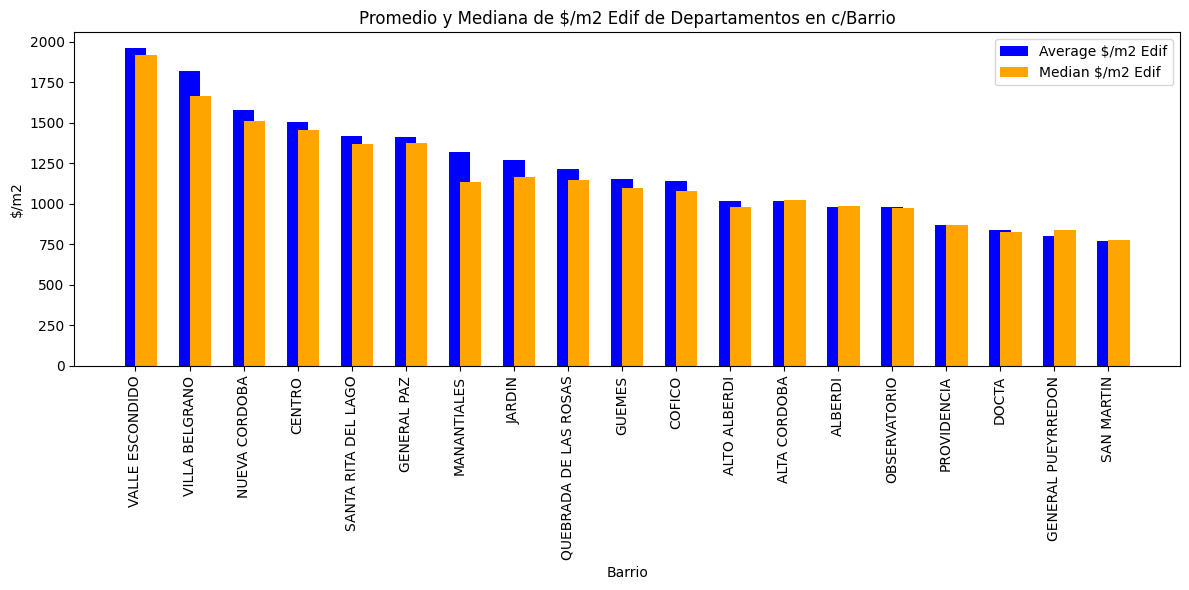

In [22]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 Edif de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


23


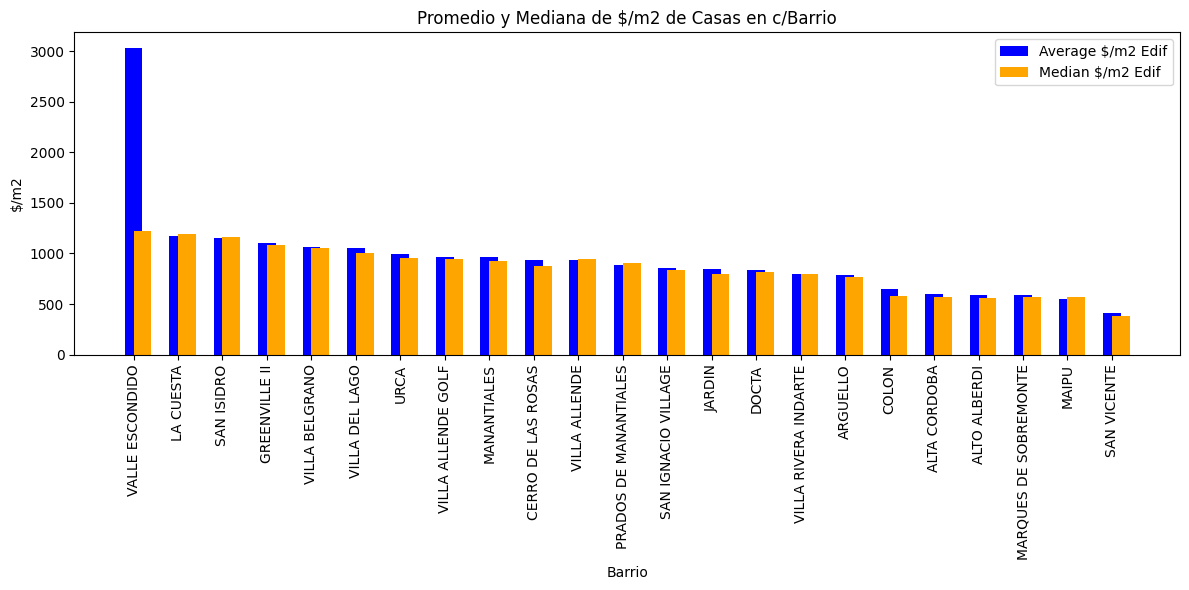

In [10]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
casas_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
casas_df = casas_df[(casas_df['tipoPropiedad'] == 'CASA') & (casas_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = casas_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, casas_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, casas_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2 Edif', color='orange', align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
filt = inmuebles_filt["coordX"].notna() & (inmuebles_filt['tipoPropiedad'] == 'DEPARTAMENTO')
ubicados = inmuebles_filt.loc[filt]

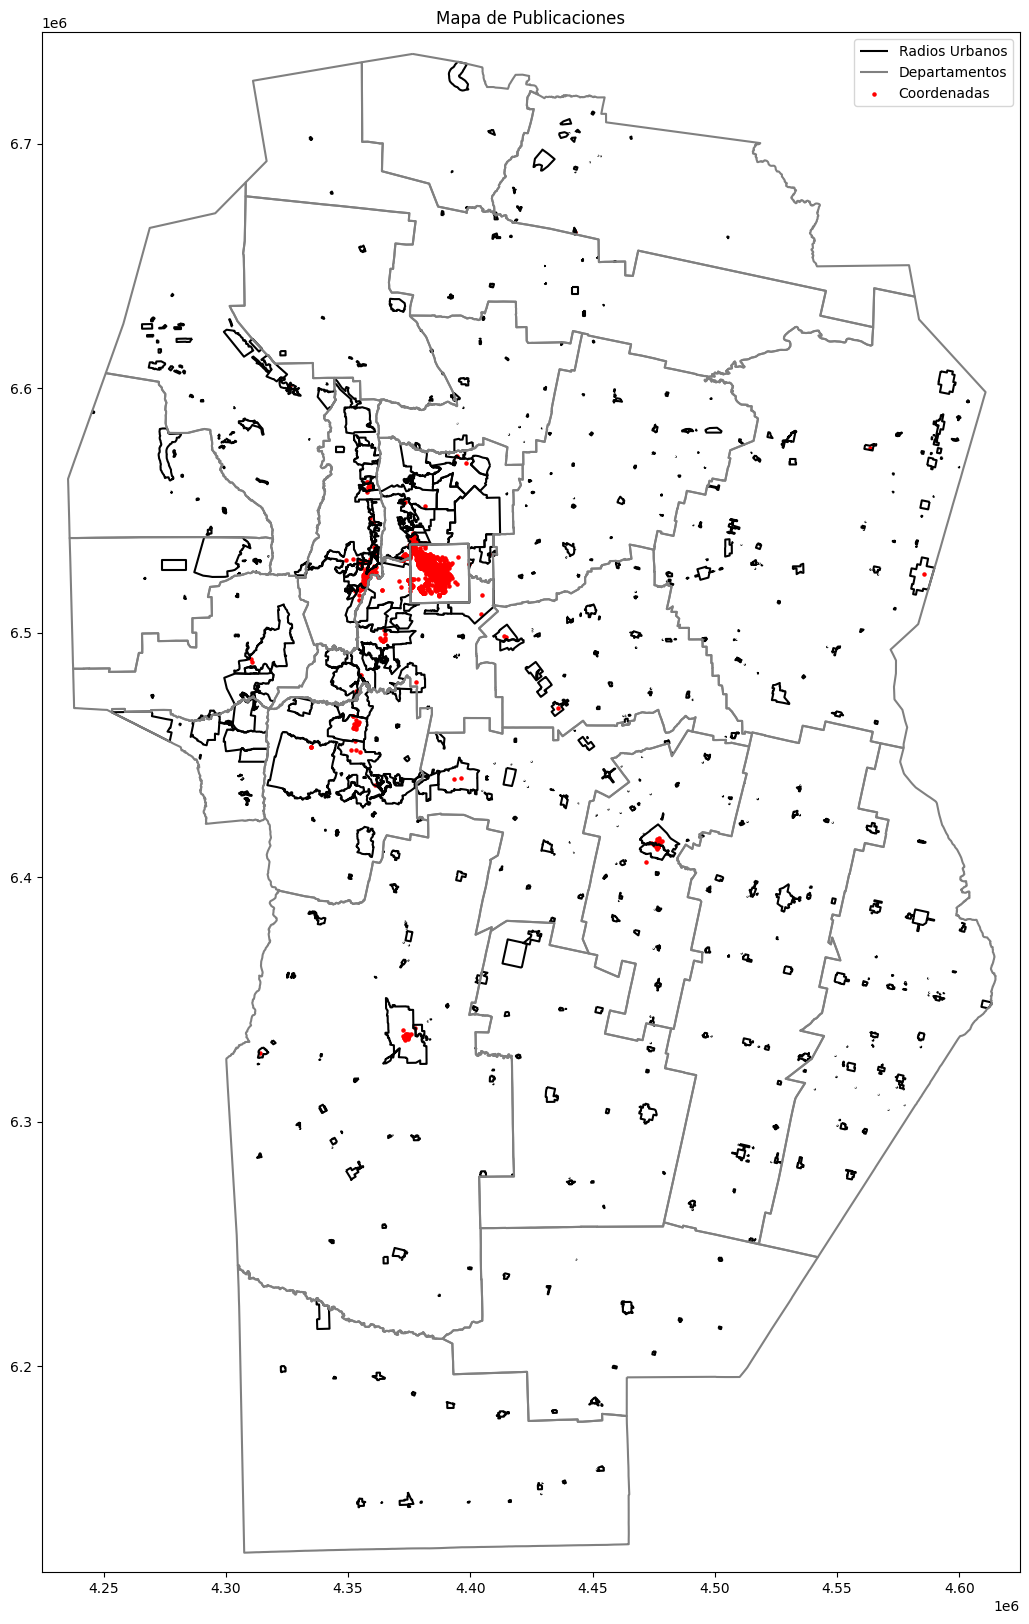

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
target_crs = pyproj.CRS("EPSG:22174")  # POSGAR 98 / Argentina 4
# Create a transformer
transformer = pyproj.Transformer.from_crs(source_crs, target_crs, always_xy=True)
longitudes, latitudes = transformer.transform(ubicados['coordY'], ubicados['coordX'])

center = (4424708.768444949, 6445660.828924287)

# Read the shapefiles
radios_urbanos_shapefile = './utils/maps/radios_urbanos.shp'
barrios_shp = './utils/maps/departamentos.shp'

radios_urbanos = gpd.read_file(radios_urbanos_shapefile)
barrios = gpd.read_file(barrios_shp)

# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
radios_urbanos.boundary.plot(ax=ax, color='black', label='Radios Urbanos')
barrios.boundary.plot(ax=ax, color='gray', label='Departamentos')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes, latitudes, color='red', label='Coordenadas', s=5)

map_padding = 350000  # Increase the padding for more zoom-out effect
ax.set_xlim(center[0] - map_padding + 150000, center[0] + map_padding - 150000)
ax.set_ylim(center[1] - map_padding + 20000, center[1] + map_padding - 50000)

# Set the title and legend
ax.set_title('Mapa de Publicaciones')
ax.legend()

# Show the plot
plt.show()


In [13]:
particulares = inmuebles_filt.loc[inmuebles_filt['vendedor'] == 'PARTICULAR']
filt = particulares['barrio'].str.contains('MANANTIALES', na=False) & particulares['activo']
particulares.loc[filt]

,id,tipoPropiedad,precioUSD,fechaUltimaActualizacion,vendedor,terrenoTotal,terrenoEdificado,cantDormitorios,cantBanos,cantCochera,barrio,ciudad,coordX,coordY,activo,URL,precio_m2_total,precio_m2_edif
12500,51887240,DEPARTAMENTO,80000,2023-06-22,PARTICULAR,60.0,50.0,1.0,1.0,1.0,LOS MANANTIALES,VILLA CARLOS PAZ,-31.422648,-64.502112,True,https://www.zonaprop.com.ar/propiedades/dpto.-...,1333.333333,1600.000000
13492,52072748,CASA,140000,2023-07-27,PARTICULAR,125.0,123.0,3.0,2.0,2.0,MIRADORES DE MANANTIALES,CORDOBA,-31.408936,-64.204367,True,https://www.zonaprop.com.ar/propiedades/apto-b...,1120.000000,1138.211382
18371,52033087,CASA,130000,2023-07-22,PARTICULAR,250.0,127.0,2.0,1.0,1.0,COLINAS DE MANANTIALES,CORDOBA,-31.480492,-64.266764,True,https://www.zonaprop.com.ar/propiedades/casa-p...,520.000000,1023.622047
19456,52018338,CASA,130000,2023-07-17,PARTICULAR,180.0,147.0,3.0,2.0,2.0,MIRADORES DE MANANTIALES II,CORDOBA,-31.457685,-64.243726,True,https://www.zonaprop.com.ar/propiedades/venta-...,722.222222,884.353741
25958,51999091,CASA,440000,2023-07-15,PARTICULAR,1000.0,278.0,4.0,2.0,2.0,MANANTIALES COUNTRY,CORDOBA,-31.448014,-64.225121,True,https://www.zonaprop.com.ar/propiedades/casa-e...,440.000000,1582.733813
25962,52033405,CASA,285000,2023-07-25,PARTICULAR,360.0,250.0,3.0,2.0,2.0,ALTOS DE MANANTIALES,CORDOBA,-31.461015,-64.234775,True,https://www.zonaprop.com.ar/propiedades/altos-...,791.666667,1140.000000


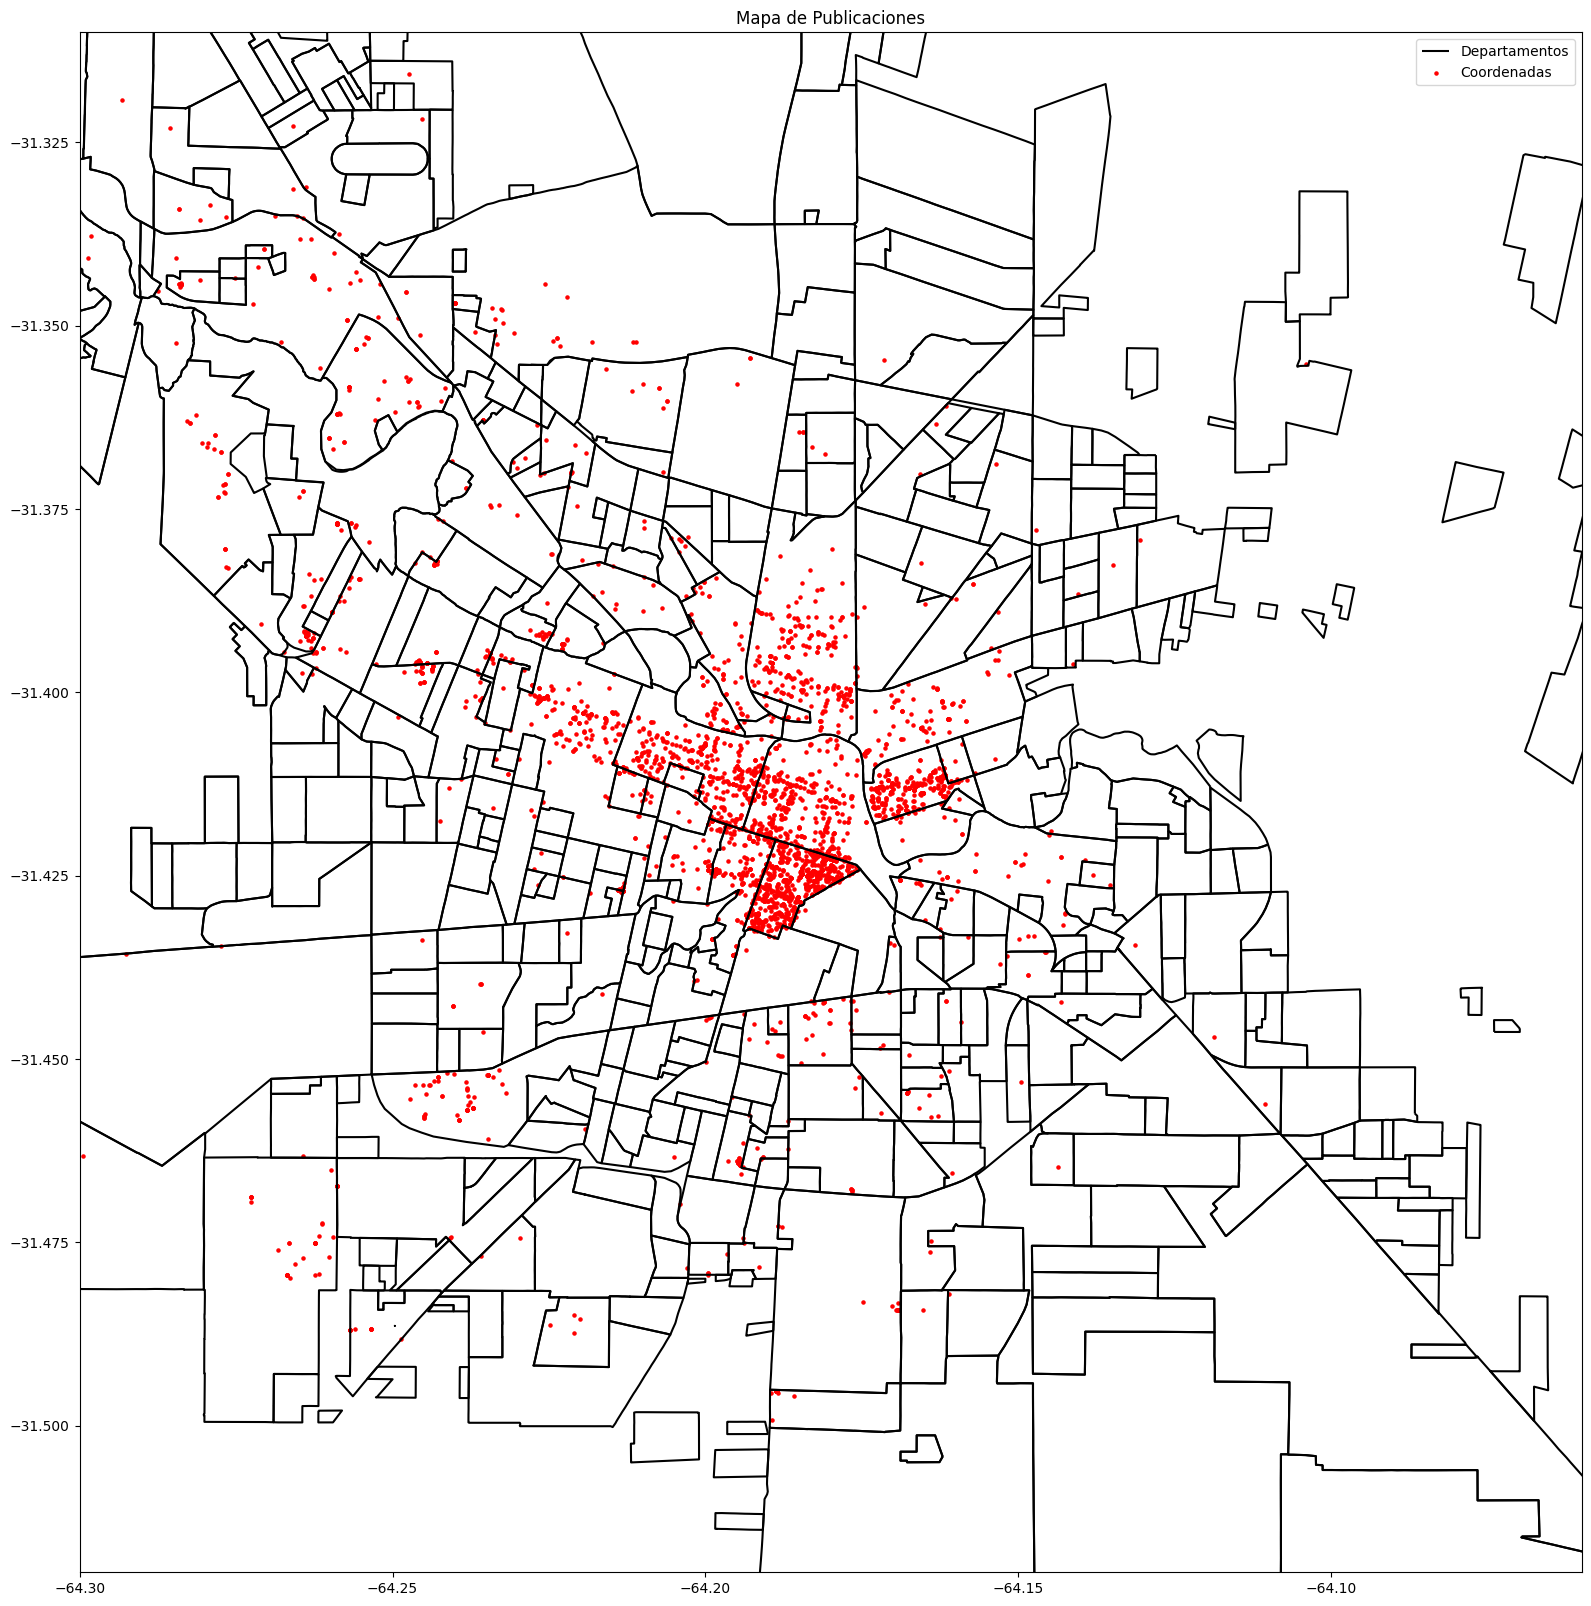

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
# Create a transformer
latitudes = ubicados['coordX']
longitudes = ubicados['coordY']

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)
center = (-64.18365408774824, -31.41675384652835)


# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
barrios.boundary.plot(ax=ax, color='black', label='Departamentos')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes, latitudes, color='red', label='Coordenadas', s=5)

map_padding = 0.15  # Increase the padding for more zoom-out effect
ax.set_xlim(-64.30, -64.06)
ax.set_ylim(-31.52, -31.31)

# Set the title and legend
ax.set_title('Mapa de Publicaciones')
ax.legend()

# Show the plot
plt.show()


In [15]:
manantiales = inmuebles_filt['barrio'].str.contains('MANANTIALES', na=False) & inmuebles_filt['activo'] & inmuebles_filt['coordX'].notna()
manantiales = inmuebles_filt[manantiales]
manantiales

,id,tipoPropiedad,precioUSD,fechaUltimaActualizacion,vendedor,terrenoTotal,terrenoEdificado,cantDormitorios,cantBanos,cantCochera,barrio,ciudad,coordX,coordY,activo,URL,precio_m2_total,precio_m2_edif
6917,51879593,DEPARTAMENTO,91200,2023-06-21,INMOBILIARIA,61.0,43.0,1.0,1.0,1.0,MANANTIALES,CORDOBA,-31.457015,-64.238106,True,https://www.zonaprop.com.ar/propiedades/vendo-...,1495.081967,2120.930233
7938,51921732,DEPARTAMENTO,139700,2023-06-28,INMOBILIARIA,71.0,71.0,2.0,1.0,1.0,MANANTIALES,CORDOBA,-31.457015,-64.238106,True,https://www.zonaprop.com.ar/propiedades/dpto-3...,1967.605634,1967.605634
8232,51887158,DEPARTAMENTO,82000,2023-06-22,INMOBILIARIA,62.0,54.0,1.0,1.0,1.0,DEPARTAMENTO DE 1 DORMITORIO CON COCHERA EN CA...,CORDOBA,-31.455102,-64.242042,True,https://www.zonaprop.com.ar/propiedades/depart...,1322.580645,1518.518519
11251,52080892,DEPARTAMENTO,90000,2023-07-29,INMOBILIARIA,71.0,71.0,2.0,1.0,1.0,COSTAS DE MANANTIALES,CORDOBA,-31.452244,-64.234819,True,https://www.zonaprop.com.ar/propiedades/depart...,1267.605634,1267.605634
11505,51917367,DEPARTAMENTO,91000,2023-06-28,INMOBILIARIA,61.0,49.0,1.0,1.0,1.0,MANANTIALES,CORDOBA,-31.457015,-64.238106,True,https://www.zonaprop.com.ar/propiedades/vendo-...,1491.803279,1857.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28073,52116621,DEPARTAMENTO,82000,2023-08-04,INMOBILIARIA,87.0,75.0,2.0,2.0,NaN,MANANTIALES,CORDOBA,-31.467356,-64.258919,True,https://www.zonaprop.com.ar/propiedades/en-poz...,942.528736,1093.333333
28085,52091458,DEPARTAMENTO,138000,2023-08-01,INMOBILIARIA,75.0,75.0,1.0,1.0,1.0,MANANTIALES,CORDOBA,-31.453902,-64.238050,True,https://www.zonaprop.com.ar/propiedades/depart...,1840.000000,1840.000000
28242,52119737,DEPARTAMENTO,128000,2023-08-05,INMOBILIARIA,125.0,123.0,3.0,3.0,2.0,MANANTIALES,CORDOBA,-31.453524,-64.245083,True,https://www.zonaprop.com.ar/propiedades/vendo-...,1024.000000,1040.650407
28269,52089345,CASA,89500,2023-08-03,INMOBILIARIA,110.0,92.0,3.0,2.0,2.0,PRADOS DE MANANTIALES,CORDOBA,-31.463472,-64.231567,True,https://www.zonaprop.com.ar/propiedades/prados...,813.636364,972.826087


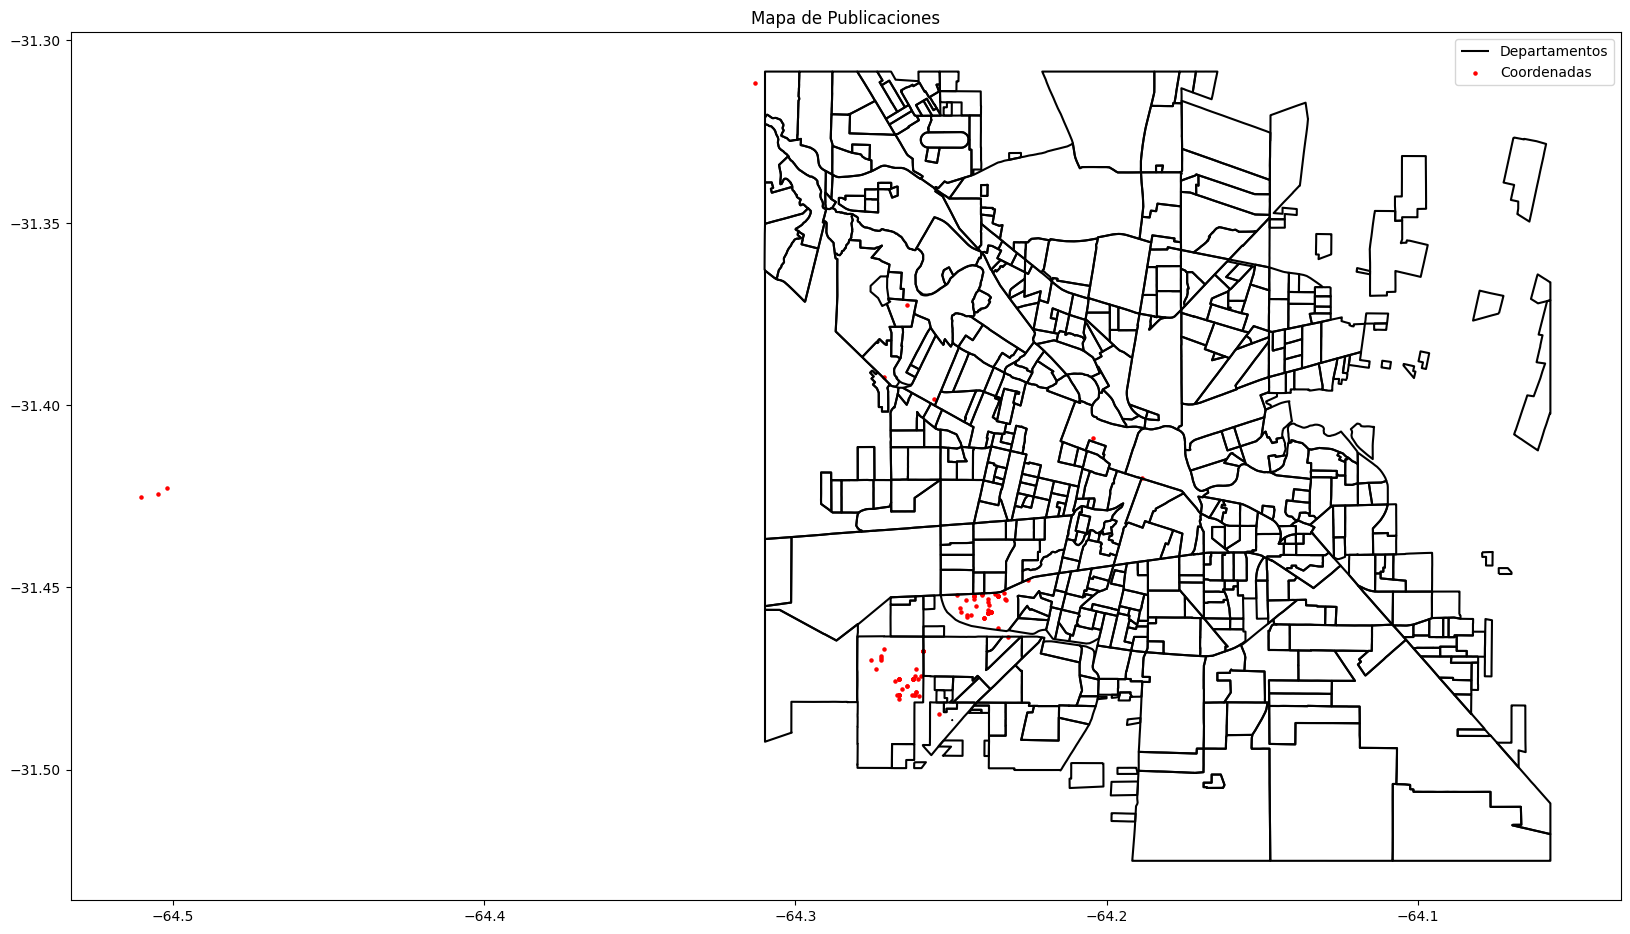

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj

# Define the source and target coordinate systems
source_crs = pyproj.CRS("EPSG:4326")  # WGS84 (latitude and longitude)
# Create a transformer
latitudes = manantiales['coordX']
longitudes = manantiales['coordY']

# Read the shapefiles
barrios_shp = './utils/maps/barrios.shp'
barrios = gpd.read_file(barrios_shp)

mean = (longitudes.median(), latitudes.median())

# Create a plot with the boundaries of both shapefiles
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the boundaries of radios_urbanos shapefile
barrios.boundary.plot(ax=ax, color='black', label='Departamentos')

# Plot the transformed points with smaller markers and more transparency
ax.scatter(longitudes, latitudes, color='red', label='Coordenadas', s=5)

# Set the title and legend
ax.set_title('Mapa de Publicaciones')
ax.legend()

# Show the plot
plt.show()
